># Etude du dataset sur des patients atteints du SARS-CoV-2
- Au cours de l'étude du dataset (https://www.kaggle.com/einsteindata4u/covid19) nous allons tenter de construire un modèle capable de prédire si un patient est atteint du SARS-CoV-2 en fonction des données qui nous sont fournies.
- Pour ce faire nous définissons plus bas les différentes étapes de l'étude que nous allons mener.

>>## **Exploratory Data Analysis**

- **Objectifs**: *comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation.*

- **Analyse de la forme**:

	- *Target value*: ["SARS-Cov-2 exam result"] (positive:1, negative: 0)
	- *Nombre des lignes et de colonnes*: (5644, 111) 
	- *Identification des valeurs manquantes*: 
		- bcp de NaN --> 3 groupes distincts (89-100% vides, 75-76% vide, 0% vide)
		- ~90% vide : test de taux sanguins (type globules blancs)
		- ~76% vide: type test viraux (H1N1 ...)
		- 0% données personneles patient
	- Types de variables:
		- float64    70
		- object     37
		- int64       4 
	
- **Analyse du fond**:

	- *Visualisation de la target*:
      - 10% de positifs (["SARS-Cov-2 exam result"]), sous représentée

	- *Compréhension des différentes variables (recherche)*:
      - Variables continues (tests sanguins): Etude de la distribution des variables
        - Variables standardisées: Médiane en 0

        - Distribution normales

        - Distribution asymétriques (coef asymétrique positif ou négatif)

      - Age quantile: Diffile à interpréter, l'auteur n'a pas donné de signification sur cette découpe en 19 quantiles différents, on ne peut pas en déduire quoi que ce soit si ce n'est que ces données ont été transformées.
      On peut cependant attester de la variété de tranches d'âges représentées grâce à la distribution et la variance.
      
      - Variables qualitatives (labellisées): Binaires (0,1), virales essentiellement, Rhinovirus semble avoir la plus grande variance (à étudier)
  
  - Visualisation des relations : features/target
	
  

>>## **Pre-processing**

- **Objectif**: ***transformer le data pour le mettre dans un format propice au machine learning***

  - Identification des outliers   
  - Création du Train Set / Test Set
  - Élimination des NaN : dropna(), imputation, colonne"vides"
  - Encodage
  - Suppression des outliers néfastes au modèle
  - Feature selection
  - Feature engineering
  - Feature scaling

>> ## **Modelling**

- **Objectif**: ***développer un modèle de machine learning capable de répondre a l'objectif final.***

	- Définir une fonction d'évaluation
	- Entrainement de différents modèles
	- Optimisation avec GridSearchCV
	- Analyse des erreurs et retour au Preprocessing / EDA

>> ## **Learning Curve et prise de décision**
- Prise de décisions en fonction des résultats obtenus

> # **1 - Exploration des données**

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import du dataset
from google.colab import files
uploaded = files.upload()

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# Lecture et copie de dataset
data= pd.read_excel("dataset.xlsx")
df= data.copy()

In [ ]:
# Taille du dataset
df.shape

(5644, 111)

In [ ]:
# Ajout de paramètre pour afficher les 111 colonnes
pd.set_option('display.max_rows', 111)
pd.set_option('display.max_column', 111)

In [ ]:
df.head(5)

In [ ]:
#@title
# Types des colonnes
column_type={}
for column in df.columns:
  if df[column].dtype in column_type:
    column_type[df[column].dtype].append(column)
  else:
    column_type[df[column].dtype] = []
    column_type[df[column].dtype].append(column)

for item in column_type.items():
  print(item, "\n\n")

(dtype('O'), ['Patient ID', 'SARS-Cov-2 exam result', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Influenza B, rapid test', 'Influenza A, rapid test', 'Strepto A', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Hyaline cylinders', 'Urine - Granular cylinders', 'Urine - Yeasts', 'Urine - Color']) 


(dtype('int64'), ['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)']) 



In [ ]:
# Vue globale des types
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

In [ ]:
# NaN dans colonnes
df.isnull().sum()

>- On remarque que l'on a énormément de colonnes vides et 3 groupes de colonnes distincts (emptiness):
>>  - ~[100-90]%
  - ~[89-85]%
  - ~76%  
  - 0% 

In [ ]:
# % de NaN dans les colonnes
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)

- *Heatmap des valeurs nulles* (blanc=NaN, noir= valeur)
- Seules quelques colonnes bien renseignées
- *Lignes noires*: suite de rows dont colonnes renseignées, indiquant potentiel lien entre les valeurs

In [ ]:
# cbar= false, cacher légende de colorisation de la heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df.sample(frac=0.75).isnull(), 
            cbar=False)

>- On supprime les colonnes vides à plus de 90%
>- On passe de 111 à 39 colonnes --> 72 colonnes mise de côté

In [ ]:
df= df[df.columns[df.isna().sum()/df.shape[0]<0.9]]
df.shape

(5644, 39)

In [ ]:
df.columns

> ## **2 - Analyse de fond**

> - La colonne patient ID n'apporte rien à l'étude (aucune info exploitable, donnée de santé anonymisée pour raisons évidente de confidentialité) --> On la supprime
-  **Target variable**: ['SARS-Cov-2 exam result']
  - Indique si une personne est positive ou négative au test du SARS-Cov-2

In [ ]:
df= df.drop("Patient ID",axis= 1)

In [ ]:
df.columns

> - On étudie la répartition de nos classes dans le dataset au sein de la target variable, afin de savoir si une classe est sous représentée
  - Positif: ~10%
  - Négatif: ~90%

In [ ]:
df["SARS-Cov-2 exam result"].value_counts(normalize= True)*100

negative    90.113395
positive     9.886605
Name: SARS-Cov-2 exam result, dtype: float64

## Variables continues
> - On a plusieurs colonnes dont les variables sont continues (float64), on étudie donc leur distribution afin de connaitre leur densité de propabilité au sein du dataset.
- On observe aussi que la plupart des distributions sont centrées en 0 ce qui permet de dire facilement que ces données ont été standardisées
- Quelques distributions normales (distribution centrée sur la médiane)
- Egalement des distribution asymétriques:
  - Coef asymétries positives,  (queue de distribution étalée à droite de la médiane)
  - Coef asymétries négatives (queue de distribution étalée à gauche de la médiane)
  

In [ ]:
for col in df.select_dtypes('float'):
  plt.figure() 
  sns.distplot(df[col])
  plt.figure()
  sns.boxplot(df[col])


## Age quantile: analyse
> - Concernant la colonne 'Patient age quantile', on peut pas savoir précisément son unité de mesure, en effet aucune indication n'a été donnée dans le descriptif du datatset.
  - On peut simplement penser que c'est une transformation mathématique
  - Durée de vie d'une personne est en moyenne de 80 ans --> 19 quantiles --> 4.21052 ans par quantile ? 

In [ ]:
df['Patient age quantile'].unique()

array([13, 17,  8,  5, 15,  9, 16,  1, 14, 11,  0,  3, 10,  6, 12, 19,  7,
       18,  2,  4])

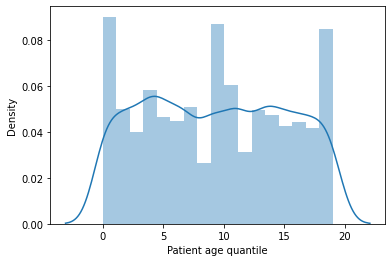

In [ ]:
# Distribution de densité de probabilité large, grand écart-type, grande variété de valeurs
sns.distplot(df['Patient age quantile'])

In [ ]:
# Variance de la colonne: grande vérifie hypothèse écart-type (V= ecart-type**2)
# Données uniques: Vérifie définitivement la diversité d'âge des patient
print(f"Variance: {df['Patient age quantile'].var()},\nDonnées uniques: {df['Patient age quantile'].unique()}")

Variance: 33.384166399468896,
Données uniques: [13 17  8  5 15  9 16  1 14 11  0  3 10  6 12 19  7 18  2  4]


> ## Object column
- Analyse des variables catégorielles (type object)
- Parainfluenza 2: variance nulle
- Rhinovirus/Enterovirus: variance élevée
- Données de test viraux
- Catégories binaires (0,1)

In [ ]:
# On regarde les différentes catégories de chaque variables qualitative
for col in df.select_dtypes('object'):
  print(f"{col :.<50}, {df[col].unique()}, {len(df[col].unique())}")

In [ ]:
# On peut également afficher leur variance pour savoir si une variable n'a qu'une seule catégorie ou pas de catégorie

def transform_label(x):
  """Transforme les labels négatifs:0 et positifs:1"""
  if x in ['not_detected', 'negative']:
    return 0
  if x in ['detected', 'positive']:
    return 1

features=list(df.select_dtypes('object'))
df_= df[features].applymap(transform_label)

df_[features].var().sort_values(ascending=False)

Rhinovirus/Enterovirus         0.201892
SARS-Cov-2 exam result         0.089107
Inf A H1N1 2009                0.067281
Influenza A, rapid test        0.059466
Influenza B, rapid test        0.056254
Influenza B                    0.053674
Respiratory Syncytial Virus    0.036957
CoronavirusNL63                0.032200
Coronavirus HKU1               0.014585
Parainfluenza 4                0.013866
Influenza A                    0.013127
Metapneumovirus                0.010255
Adenovirus                     0.009530
Parainfluenza 3                0.007347
Chlamydophila pneumoniae       0.006617
Coronavirus229E                0.006617
CoronavirusOC43                0.005887
Parainfluenza 1                0.002216
Bordetella pertussis           0.001478
Parainfluenza 2                0.000000
dtype: float64

> ## Relation Target/Variables
>> ### Sous-ensembles pour les patients positifs et négatifs

In [ ]:
positive_df= df[df["SARS-Cov-2 exam result"]=='positive']
negative_df= df[df["SARS-Cov-2 exam result"]=='negative']

>> ### Sous-ensembles viraux et sanguins
- On sait que l'on avait 3 catégories de colonnes en fonctions du taux de valeurs manquantes.

In [ ]:
missing_rate= df.isnull().sum()/df.shape[0]

# On vérifie notre estimation par rapport au taux de valeurs manquantes
print("Sanguins: ",df.columns[(missing_rate<0.9) & (missing_rate>0.88)])
print("Viraux: ",df.columns[(missing_rate<0.88) & (missing_rate>0.75)])

# Variables de type tests sanguins
blood_analysis_columns= df.columns[(missing_rate<0.9) & (missing_rate>0.88)]
viral_analysis_columns= df.columns[(missing_rate<0.88) & (missing_rate>0.75)]

Sanguins:  Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')
Viraux:  Index(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Influenza B, rapid test',
       'Influenza A, rapid test'],
      dtype='object')


>> ### Relation entre tests sanguins et la target
- On va étudier la distribution des tests sanguins en fonction de la distribution des cas positifs
- On observe une différence pour: 
  - Leukocytes: plus pour negative. 
  - Platelets: plus pour negatif.
  - Monocytes: plus pour positifs.

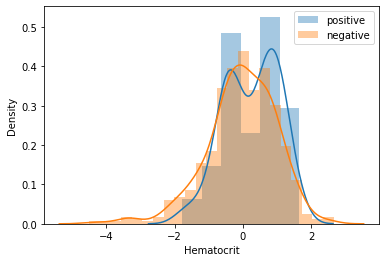

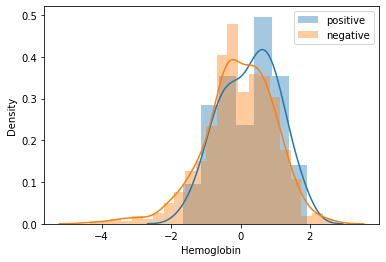

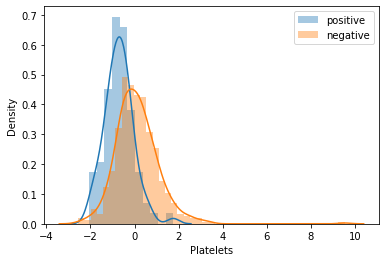

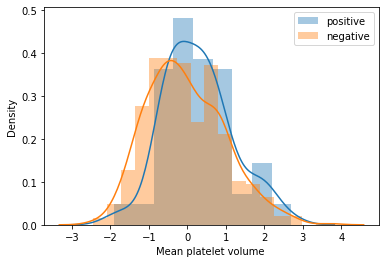

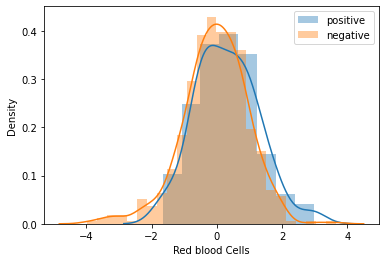

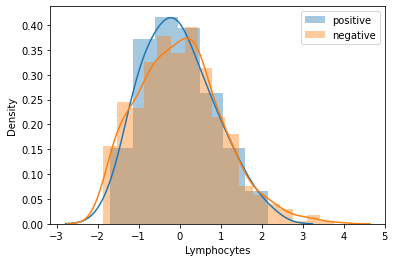

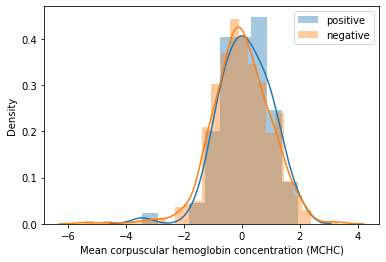

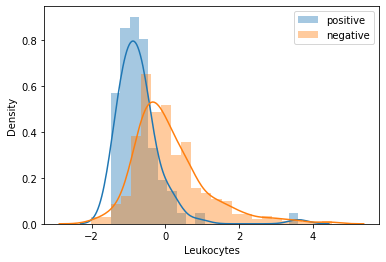

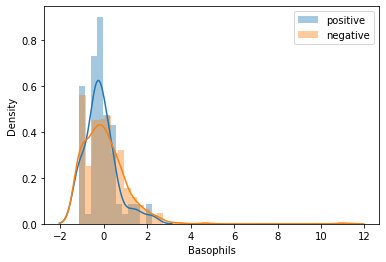

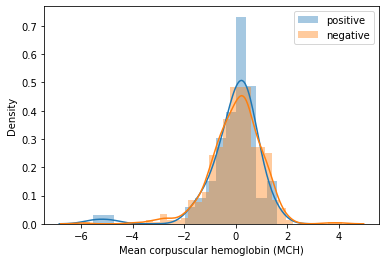

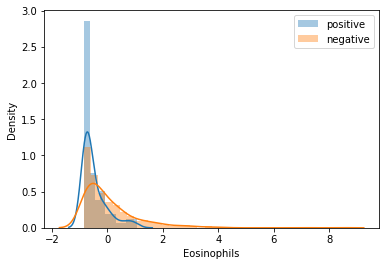

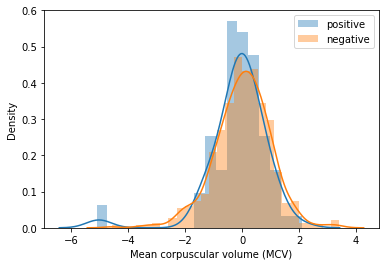

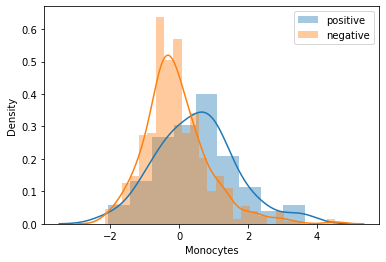

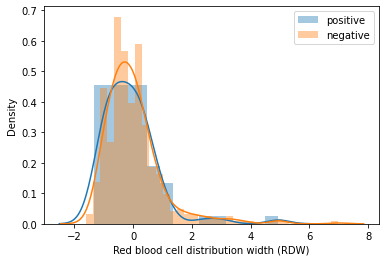

In [ ]:
for col in blood_analysis_columns:
  plt.figure()
  sns.distplot(positive_df[col], label='positive')
  sns.distplot(negative_df[col], label='negative')
  plt.legend()

>> ## Relation entre le quantile d'âge et la target
- Peu de cas positifs pour les quantiles faibles
- On pourrait en déduire que les jeunes personnes sont moins touchées que les personnes agées, en revanche, comme dit plus tôt, on ne connait pas la signification de ce 'age quantile'
- En revanche, on peut toujour la conserver pour la comparer avec le données sanguines et voir si il existe une corrélation (une personne âgée n'ayant pas les même taux sanguins qu'une jeune personne)
  - ex: Chez l'homme de plus de 70 ans, en raison de la baisse de la testostérone (facteur stimulant l'érythropoïèse) le taux d'hémoglobine est diminué de 0.3 à 0.4 g/dL
  - ex: Par exemple, l'hématocrite est en général compris entre 40 et 50 % pour les hommes et entre 37 et 46 % chez les femmes. Chez le nouveau-né, l'hématocrite est plus élevé.

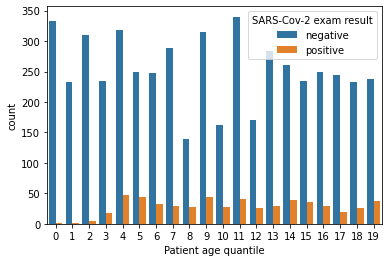

In [ ]:
sns.countplot(x="Patient age quantile", hue= "SARS-Cov-2 exam result", data= df)

>> ### Relation test viraux et quantile d'âge
- Distribution, peu de visibilité
- Heatmap, fournit déjà plus de visibilité sur les relations possibles entre la target et les test viraux
  - On remarque que le seul virus dont le test est positif pour une targte positive est la rhinovirus, dont nous avons observé la variance plus élevée que le reste des tests viraux précédemment.
    - Nous ne pouvons cependant pas en tirer de conclusion concernant un potentielle corrélation entre ces deux variables.
    - Possiblement aucun lien entre les deux variables (target et rhino)

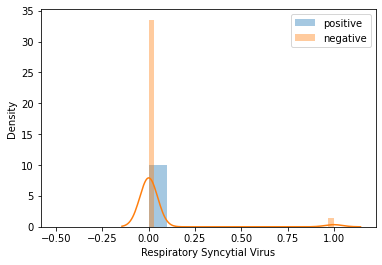

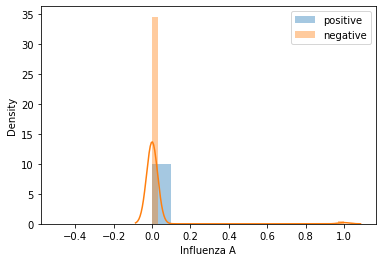

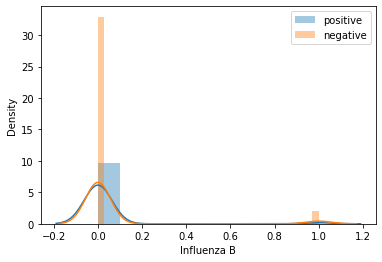

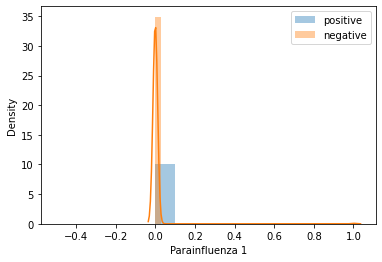

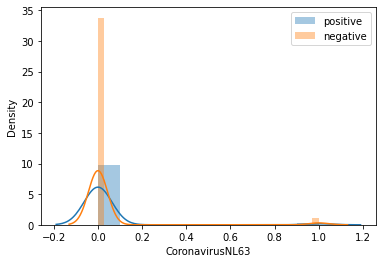

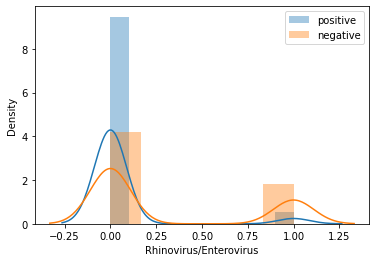

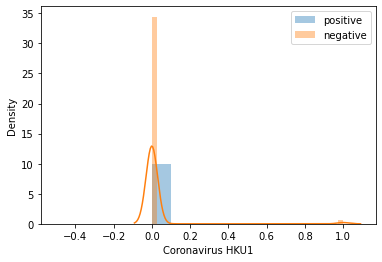

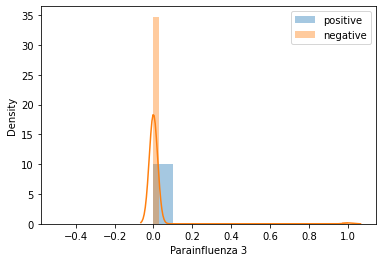

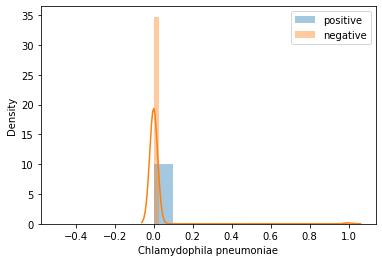

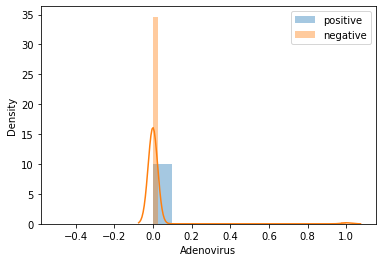

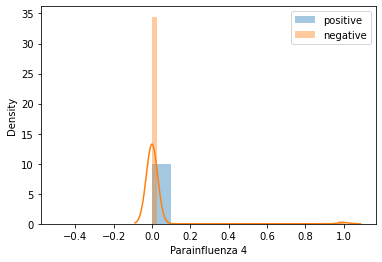

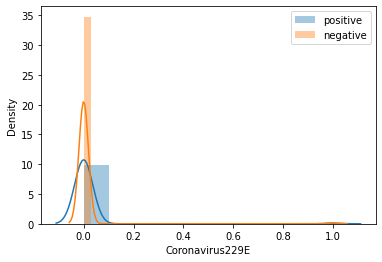

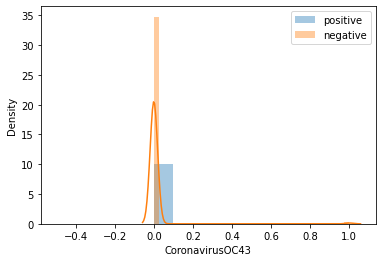

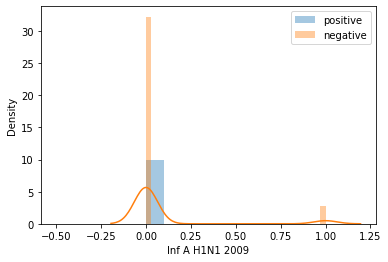

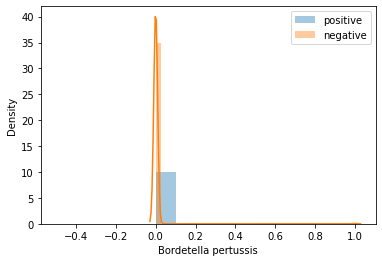

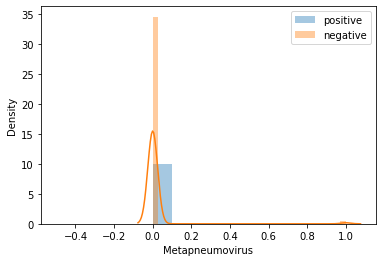

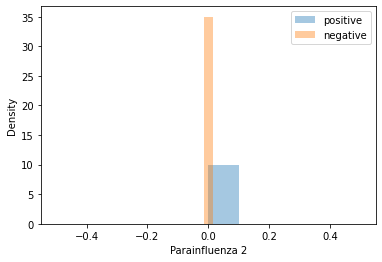

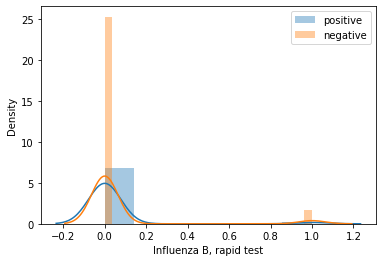

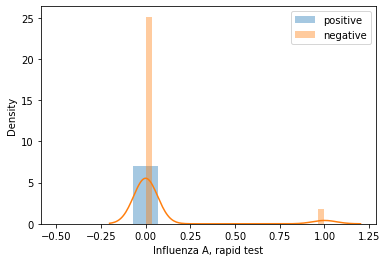

In [ ]:
_positive_df= positive_df[viral_analysis_columns].applymap(transform_label)
_negative_df= negative_df[viral_analysis_columns].applymap(transform_label)

for col in df[viral_analysis_columns].applymap(transform_label):
  plt.figure()
  sns.distplot(_positive_df[col], label='positive')
  sns.distplot(_negative_df[col], label= 'negative')
  plt.legend()


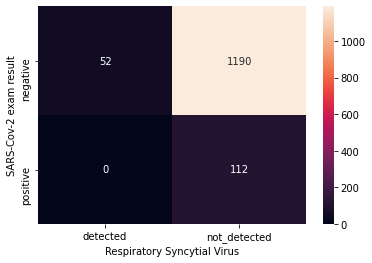

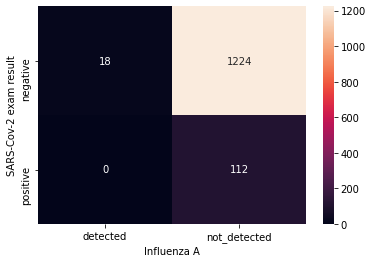

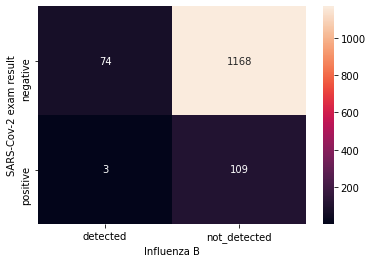

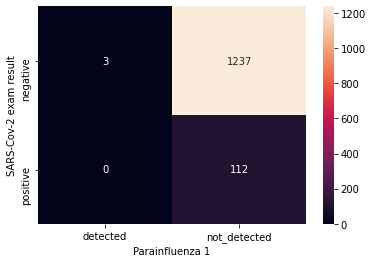

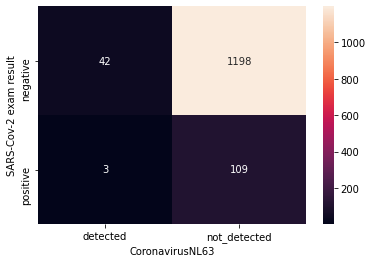

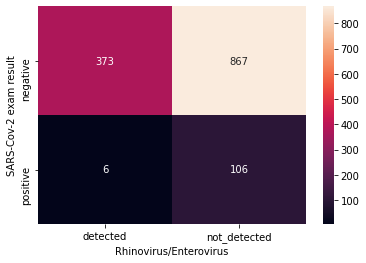

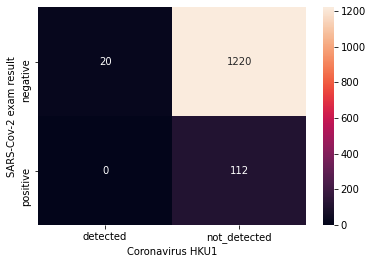

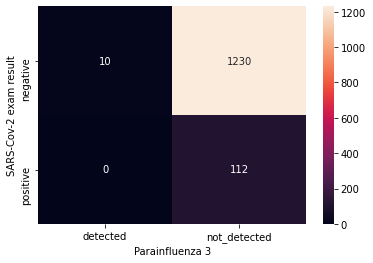

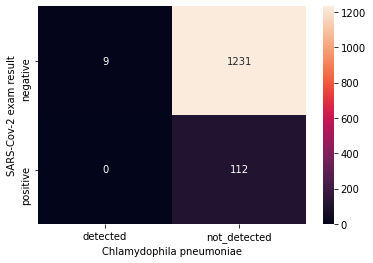

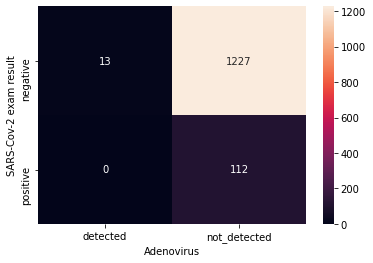

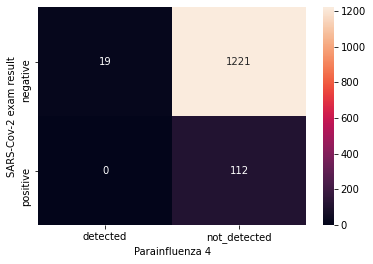

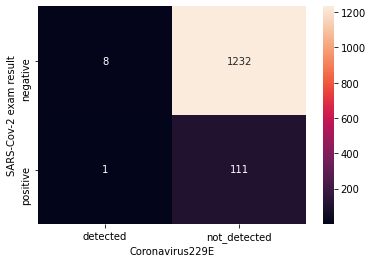

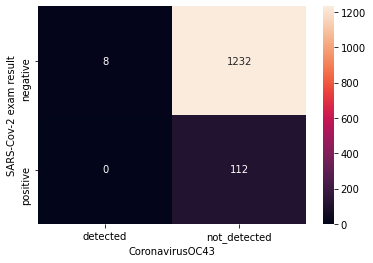

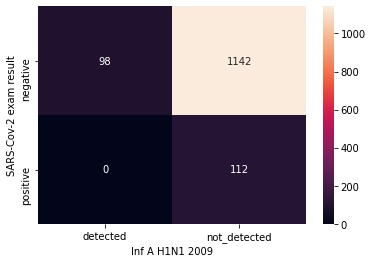

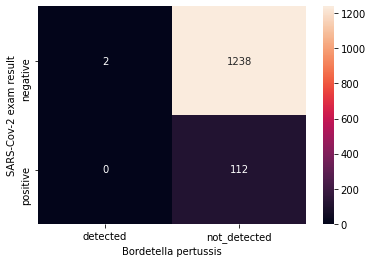

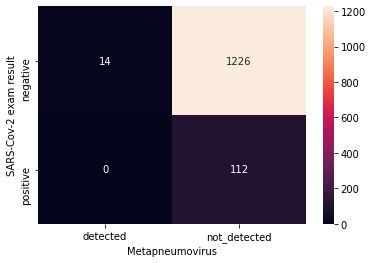

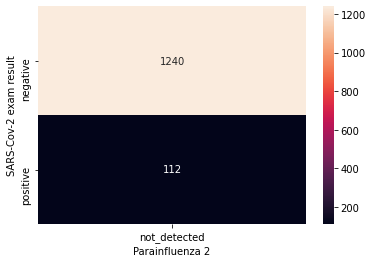

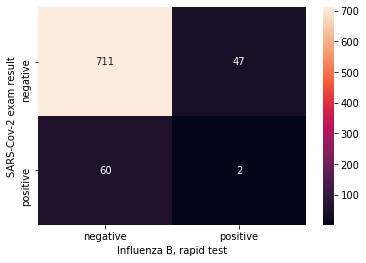

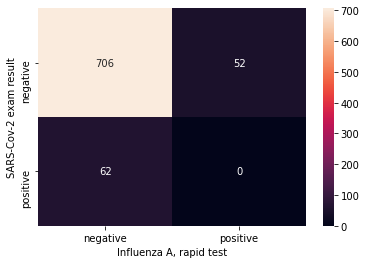

In [ ]:
for col in viral_analysis_columns:
  plt.figure()
  sns.heatmap(pd.crosstab(df["SARS-Cov-2 exam result"], df[col]),
              annot= True, fmt="d")

> ## Analyse détaillée des hypothèses précédentes
- Relation entre les variables à notre disposition:
  - Blood_analysis/Blood_analysis:
  - blood_analysis/age quantile:
  - viral_analysis/viral_analysis:
  - viral_analysis/blood_analysis:
  - hospital service (intensive etc) / target:
  - hospital service/blood:

>>  ### Blood/blood
- Correlations:
  - hemoglobin, hematocrit: +0,97
  - Mean corpuscular hemoglobin concentration (MCHC), Mean corpuscular volume (MCV): 0,9
- Et d'autres encore, heatmap à garder pour plus d'analyse si besoin est


In [ ]:
df.corr()>0.8

Patient age quantile  \
Patient age quantile                                                True   
Patient addmited to regular ward (1=yes, 0=no)                     False   
Patient addmited to semi-intensive unit (1=yes,...                 False   
Patient addmited to intensive care unit (1=yes,...                 False   
Hematocrit                                                         False   
Hemoglobin                                                         False   
Platelets                                                          False   
Mean platelet volume                                               False   
Red blood Cells                                                    False   
Lymphocytes                                                        False   
Mean corpuscular hemoglobin concentration (MCHC)                   False   
Leukocytes                                                         False   
Basophils                                                          False   
Mean corpuscular hemoglobin (MCH)                                  False   
Eosinophils                                                        False   
Mean corpuscular volume (MCV)                                      False   
Monocytes                                                          False   
Red blood cell distribution width (RDW)                            False   

                                                    Patient addmited to regular ward (1=yes, 0=no)  \
Patient age quantile                                                                         False   
Patient addmited to regular ward (1=yes, 0=no)                                                True   
Patient addmited to semi-intensive unit (1=yes,...                                           False   
Patient addmited to intensive care unit (1=yes,...                                           False   
Hematocrit                                                                                   False   
Hemoglobin                                                                                   False   
Platelets                                                                                    False   
Mean platelet volume                                                                         False   
Red blood Cells                                                                              False   
Lymphocytes                                                                                  False   
Mean corpuscular hemoglobin concentration (MCHC)                                             False   
Leukocytes                                                                                   False   
Basophils                                                                                    False   
Mean corpuscular hemoglobin (MCH)                                                            False   
Eosinophils                                                                                  False   
Mean corpuscular volume (MCV)                                                                False   
Monocytes                                                                                    False   
Red blood cell distribution width (RDW)                                                      False   

                                                    Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient age quantile                                                                            False       
Patient addmited to regular ward (1=yes, 0=no)                                                  False       
Patient addmited to semi-intensive unit (1=yes,...                                               True       
Patient addmited to intensive care unit (1=yes,...                                              False       
Hematocrit                                                                                      False       
Hemoglobin    

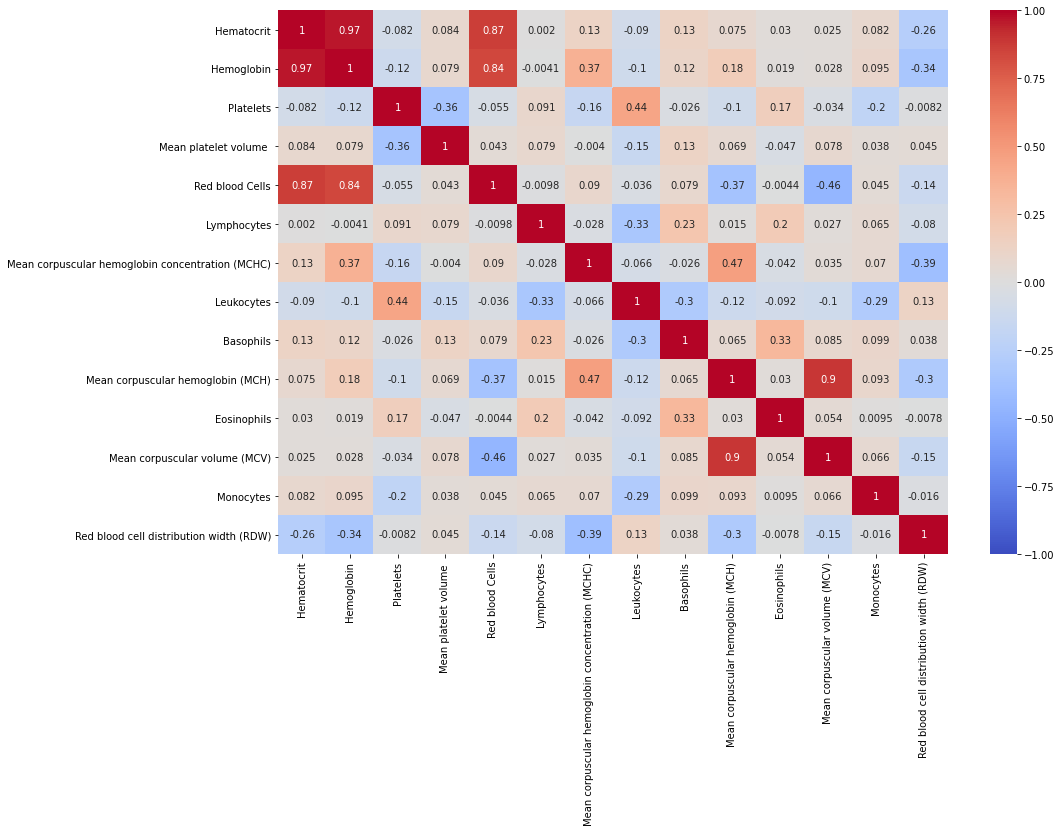

In [ ]:
plt.figure(figsize=(15, 10))

# Custom heatmap
# annot: valeur correlation, vmin= minimum color scale, cmap= color map plus visible, 
sns.heatmap(df[blood_analysis_columns].corr(), 
            annot=True, 
            vmin=-1,
            cmap= 'coolwarm')

>> ### Blood/Age quantile
- On analyse les corrélations entre ces deux variables
  - La plus grande corrélation avec l'âge est de +0,28 --> Très faible, peu de lien entre l'âge et les taux sangs.

<Figure size 432x288 with 0 Axes>

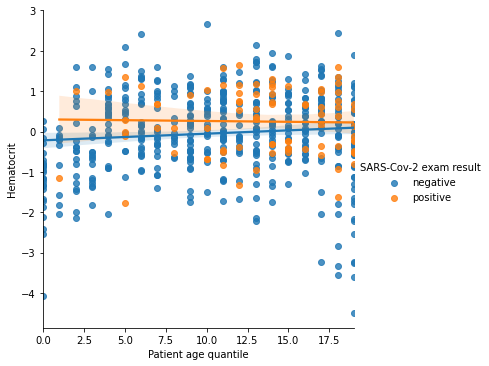

<Figure size 432x288 with 0 Axes>

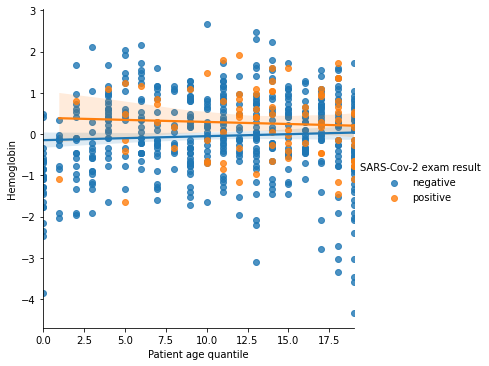

<Figure size 432x288 with 0 Axes>

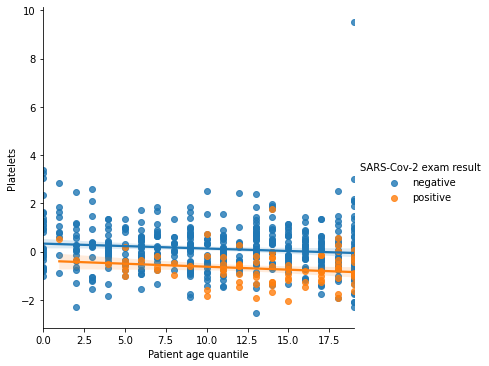

<Figure size 432x288 with 0 Axes>

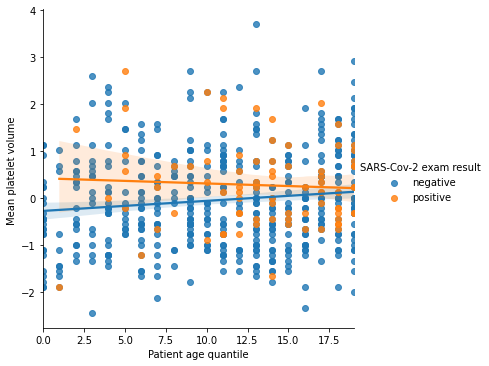

<Figure size 432x288 with 0 Axes>

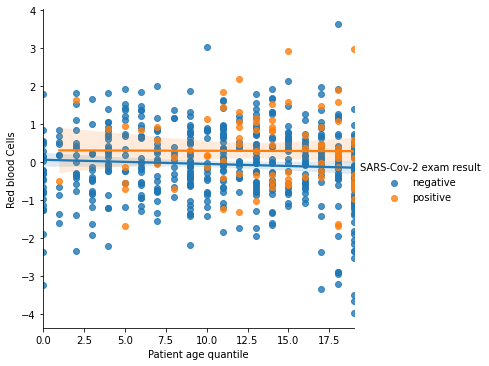

<Figure size 432x288 with 0 Axes>

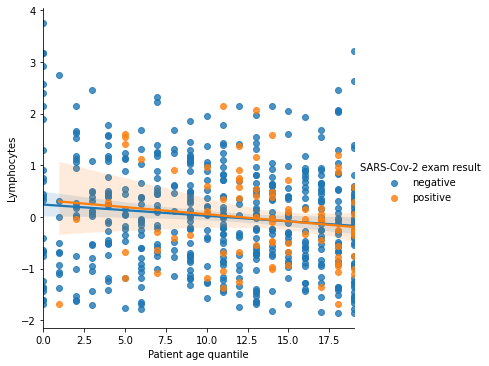

<Figure size 432x288 with 0 Axes>

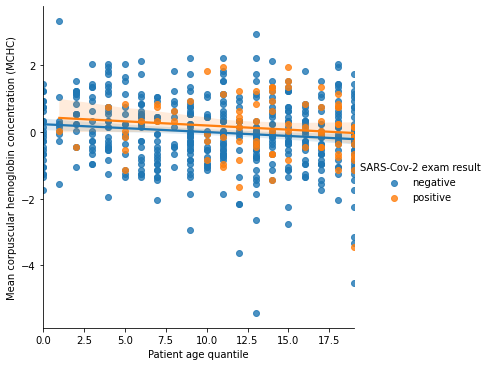

<Figure size 432x288 with 0 Axes>

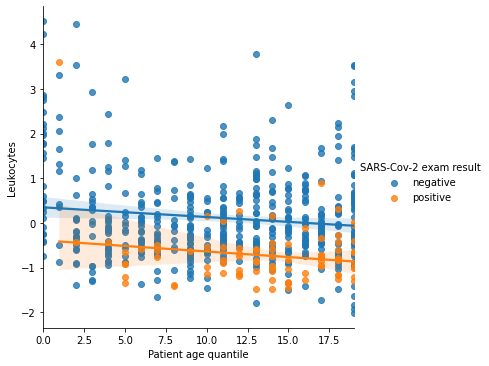

<Figure size 432x288 with 0 Axes>

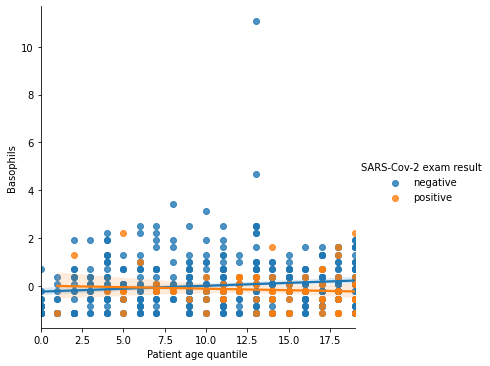

<Figure size 432x288 with 0 Axes>

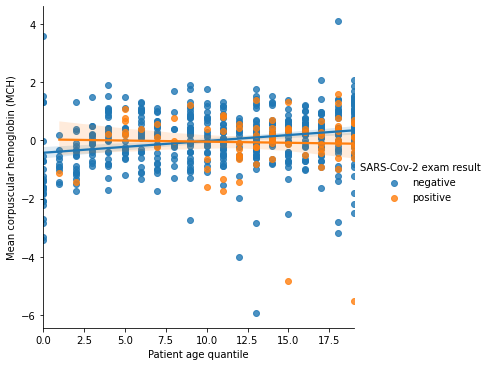

<Figure size 432x288 with 0 Axes>

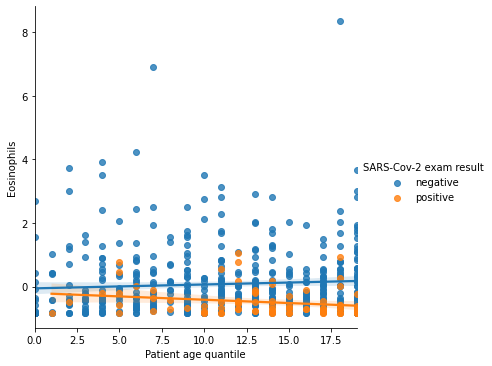

<Figure size 432x288 with 0 Axes>

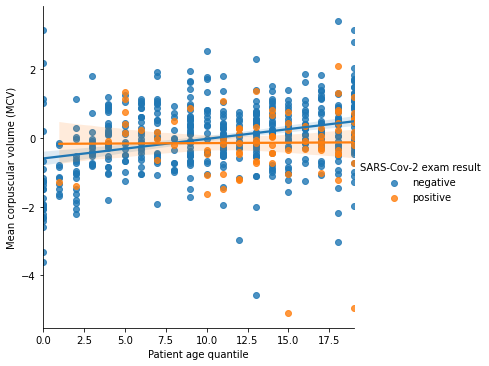

<Figure size 432x288 with 0 Axes>

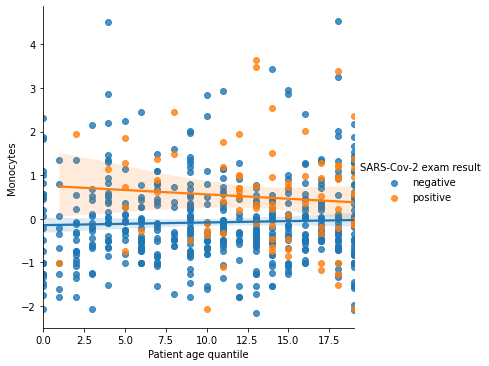

<Figure size 432x288 with 0 Axes>

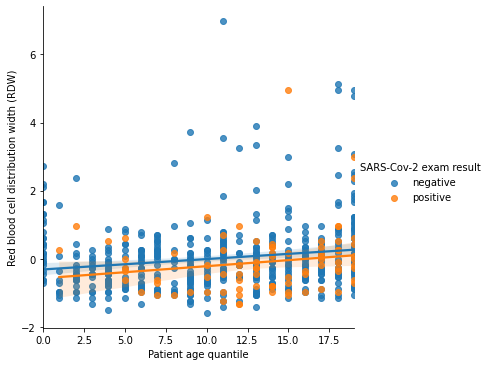

In [ ]:
# On peut afficher les courbes de régression
# Pour chaque valeurs de X, on place le point correspondant à la moyenne des valeur de Y pour ce point, on trace grâce à ces points une courbe de régression
for col in blood_analysis_columns:
  plt.figure()
  sns.lmplot(x="Patient age quantile", 
             y=col, 
             hue= 'SARS-Cov-2 exam result', # discriminant: on sépare le cas positifs de négatifs
             data= df)

In [ ]:
# On peut afficher les corrélations entre le age quantile et le sang également
df.corr()["Patient age quantile"].sort_values(ascending=False)

Patient age quantile                                     1.000000
Mean corpuscular volume (MCV)                            0.281655
Mean corpuscular hemoglobin (MCH)                        0.197394
Red blood cell distribution width (RDW)                  0.166429
Mean platelet volume                                     0.119449
Basophils                                                0.107525
Hematocrit                                               0.096808
Hemoglobin                                               0.060320
Monocytes                                                0.050962
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Eosinophils                                              0.022085
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Red blood Cells                                         -0.037510
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Lymphocyte

>> ### Viral/Viral
- On remarque que l'on a pour le virus Influenza A et B un test "normal" et un test rapide:
  - En comparant les résultats des deux tests, on se rend bien compte, notamment pour le test rapide du influenza A que les tests rapides ne sont en aucun cas précis. Effectivement, ces tests rapides peuvent donner des résultats positifs lorsque le test normal donne un résultats négatif, ce qui ne donne pas une confiance solide quand à leur étude dans le reste de l'étude.

In [ ]:
# Les tests rapides pour Influenza
[print(col) for col in df.columns if "Influenza" in col]

Influenza A
Influenza B
Influenza B, rapid test
Influenza A, rapid test


[None, None, None, None]

In [ ]:
# Comparaison des tests "normaux" et tests rapides
pd.crosstab(df['Influenza A'], df['Influenza A, rapid test'])

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

In [ ]:
pd.crosstab(df['Influenza B'], df['Influenza B, rapid test'])

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

>> ### Relation entre la maladie et les tests sanguins
- Nous allons voir si le fait d'être positif à une quelconque maladie à un lien avec les taux sanguins relevés dans les analyses sanguines dont nous disposons. Et si ces relations sont le mêmes qu'avec la target.
- Nous relevions précédemment pour la target:
  - Leukocytes: plus pour negative. 
  - Platelets: plus pour negatif.
  - Monocytes: plus pour positifs.
- Pour les autres maladies, nous relevons ici:
  - Lymphocytes: plus pour non malades
- On peut donc dire que **les relation entre les taux sanguins pour la target et pour les maladies autres que la target ne son pas les mêmes**, nous ne pouvons donc pas donner une hypothèse allant dans le sens d'un lien entre les taux sanguins et une maladie, que ce soit la target ou un autre virus.

In [ ]:
# On créé une colonne indiquant si une personne est malade (positive à une maladie ou plus)
# En excluant les tests rapides (deux dernières positions du dataset viral)df[]
df['disease positive']= np.sum(df[viral_analysis_columns[:-2]] == "detected", axis= 1) >= 1
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

In [ ]:
# On peut grâce à cette colonne créer deux data set pour les malades et non malades
disease_pos= df[df["disease positive"]==True]
disease_neg= df[df["disease positive"]== False]

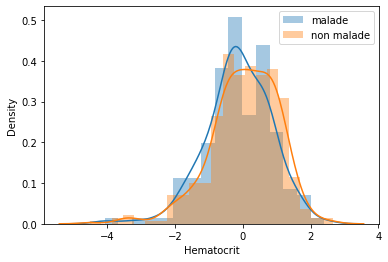

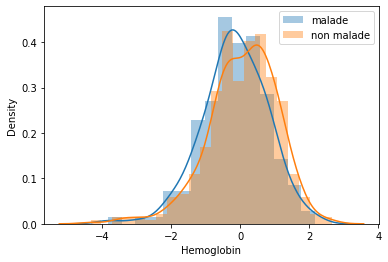

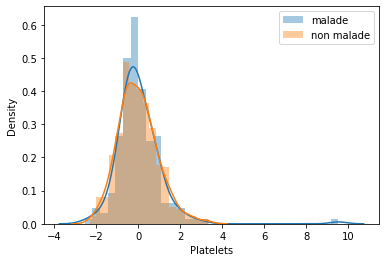

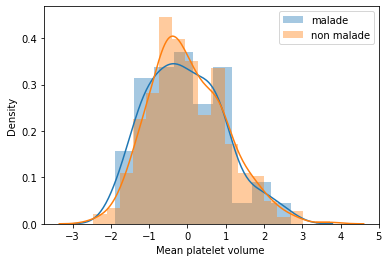

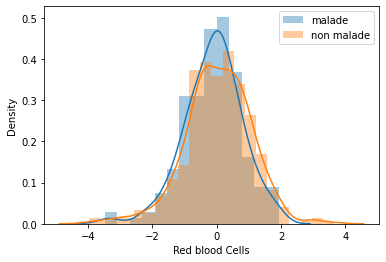

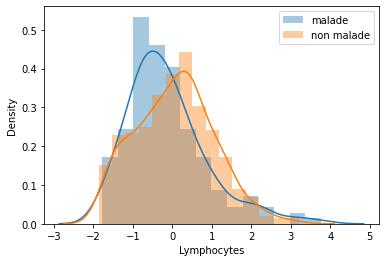

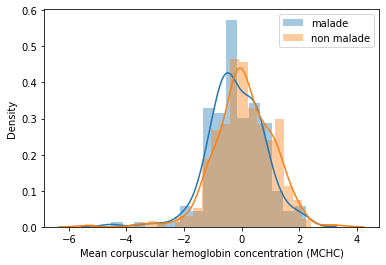

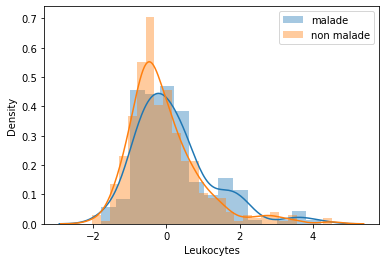

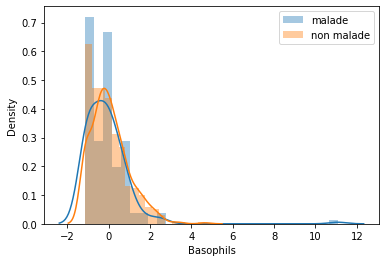

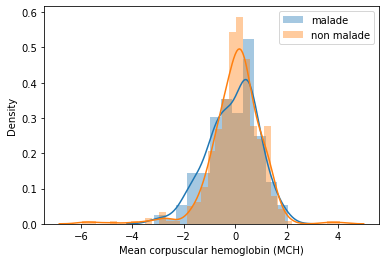

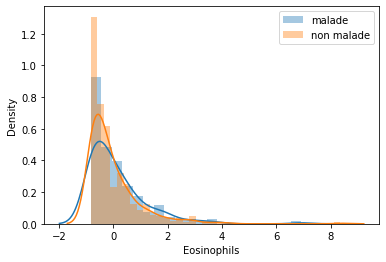

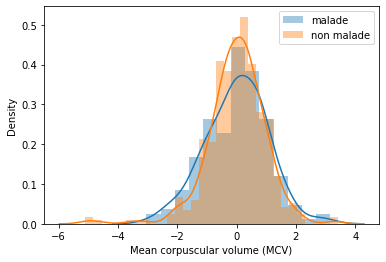

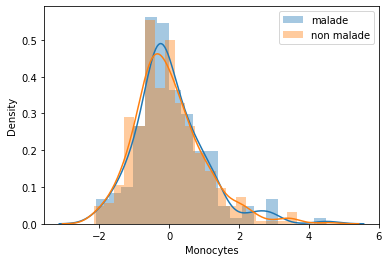

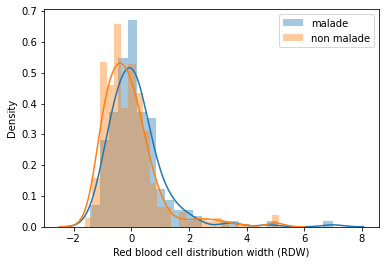

In [ ]:
# On peut afficher la distibution des tests sanguins pour ces deux data sets
for col in blood_analysis_columns:
  plt.figure()
  sns.distplot(disease_pos[col], label= 'malade')
  sns.distplot(disease_neg[col], label= 'non malade')
  plt.legend()

>> ### Relation entre l'hospitalisation et les taux sanguins
- On remarque que selon le service dans lequel une personne est envoyée, les taux sanguins peuvent varier:
  - Pour le leukocytes par ex., les personnes en soins intensifs et semi-intensifs on des taux variés (grand écart-type) contrairement aux autres qui ont une distribution bien plus centrée.

In [ ]:
# Colonnes concernant l'hospitalisation
hospitalisation_col=[col for col in df.columns if "unit" in col or "ward" in col]
hospitalisation_col

['Patient addmited to regular ward (1=yes, 0=no)',
 'Patient addmited to semi-intensive unit (1=yes, 0=no)',
 'Patient addmited to intensive care unit (1=yes, 0=no)']

In [ ]:
# On créé une fonction permettant de différencier le status hospitalier d'une personne
def patient_hospital_status(x):
  if x["Patient addmited to regular ward (1=yes, 0=no)"] ==1:
    return "surveillance"
  elif x["Patient addmited to semi-intensive unit (1=yes, 0=no)"]==1:
    return "semi-intensive"
  elif x["Patient addmited to intensive care unit (1=yes, 0=no)"]==1:
    return "intensive"
  return "unknown"

In [ ]:
# On apply cette fonction pour créer une fonction permettant 
df["status"]= df.apply(patient_hospital_status, axis= 1)

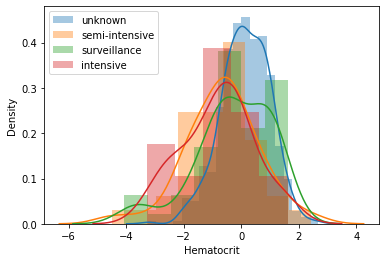

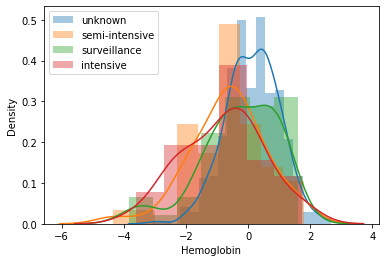

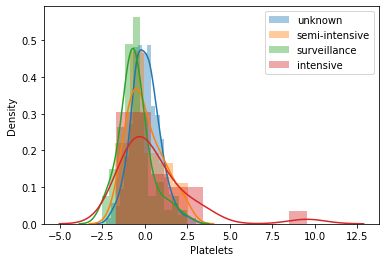

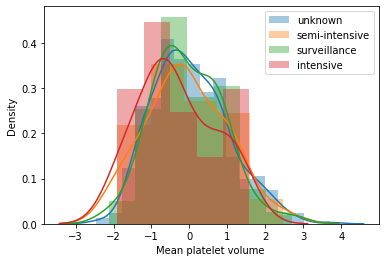

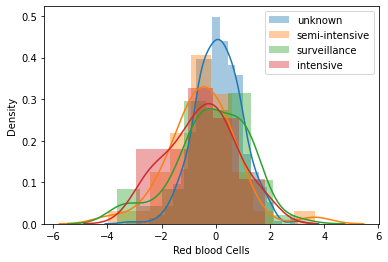

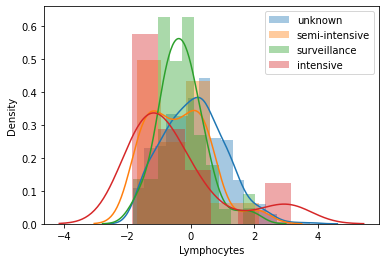

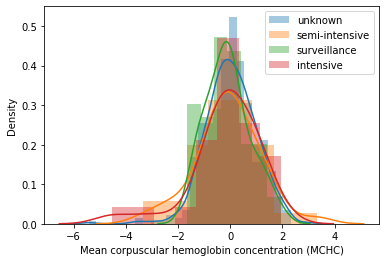

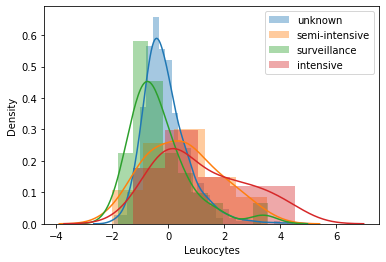

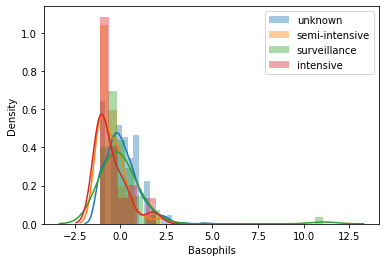

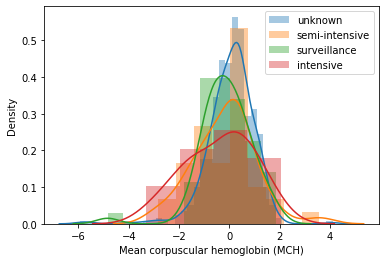

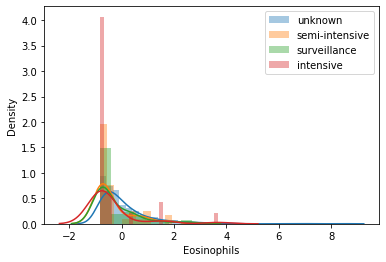

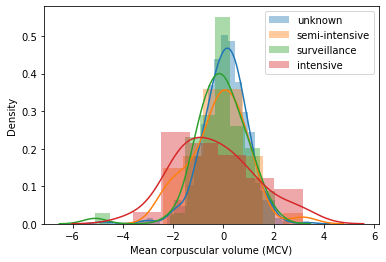

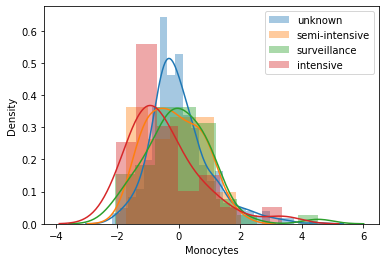

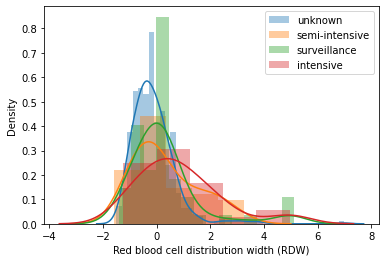

In [ ]:
# On peut maintenant visualiser le status d'une personne en fonction des différents taux sanguins
for col in blood_analysis_columns:
  plt.figure()
  for cat in df["status"].unique():
    sns.distplot(df[df["status"]==cat][col], label= cat)
  plt.legend()

> ## Analyse des valeurs manquantes du dataset
- On voudrait pouvoir dans le meilleur des cas utiliser toutes les variables à notre disposition: données virales et données sanguines. 
- En éliminant toutes les lignes sur lesquelles il manque des données, on se retrouve avec 99 valeurs, ce qui est problématique pour toute mise en place d'un modèle de prédiction quel qu'il soit.
  - En utilisant que les variables virales, il nous resterait: 1354 valeurs
  - Tests sanguins: 603
  - Seulement, on ne peut pas se séparer d'un de ces groupes de variables, comme on l'a vu, elles nous sont très utiles car possédant certains facteurs différenciants.
- Nous allons donc certainement devoir remplir ces valeurs manquantes avec une fonction fillna()

- Selon les variables que l'on pourrait conserver, les proportions de positifs et négatifs de la target:
  - Virale: neg --> 0.92, pos --> 0.07
  - Blood: neg --> 0.86, pos --> 0.13

In [ ]:
# On analyse le nombre de données perdues si on retire toutes les valeurs manquantes dans le data set
print(f"Full: {df.shape},\nNo NaN: {df.dropna().shape}")

Full: (5644, 40),
No NaN: (99, 40)


In [ ]:
# Avec seulement les variables virales
df[viral_analysis_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [ ]:
# Avec seulement les variables sanguines
df[blood_analysis_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [ ]:
# Etat de la target selon les différentes variables
df1= df[viral_analysis_columns]
df1["covid"]= df["SARS-Cov-2 exam result"]
df1.dropna()['covid'].value_counts(normalize=True)

negative    0.928302
positive    0.071698
Name: covid, dtype: float64

In [ ]:
df2= df[blood_analysis_columns]
df2["covid"]= df["SARS-Cov-2 exam result"]
df2.dropna()['covid'].value_counts(normalize=True)

negative    0.864548
positive    0.135452
Name: covid, dtype: float64

> ## Hypothèses nulles (H0)
>> - Tests des hypothèses émises plus tôt:
  - Les individus atteints du covid 19 ont des taux de Leukocytes, Monocytes et Platelets significativements différents:
    - **Hypothèse nulle**
      - H0= Les taux moyens sont EGAUX chez les individus positifs et négatifs
    - **Test de student** :
      - test-t, pour comparer les moyennes des deux groupes (positifs et négatifs) afin de vérifier si cette hypothèse nulle est vraie ou fausse. Le principe du test-t est donc de rejeter cette hypothèse nulle pour vérifier notre hypothèse initiale.
    - **Conclusion**: Pour cette hypothèse émise plus tôt, l'hypothèse nulle est rejeté, donc l'hypothèse émise est vraie. **Les patients atteints du Sars cov 2 ont des taux sanguins, listés plus bas différents de caux non atteints.**
      - Platelets--------------------------------------------------- False
      - Mean platelet volume --------------------------------------- False
      - Leukocytes-------------------------------------------------- False
      - Eosinophils------------------------------------------------- False
      - Monocytes--------------------------------------------------- False

In [ ]:
# On vérifie les dimensions de nos data set positifs et négatifs (au covid)
print(f"Positive: {positive_df.shape}\nNegative: {negative_df.shape}")

Positive: (558, 38)
Negative: (5086, 38)


In [ ]:
# On doit avoir les même dimensions pour le test 
# On sample le dataset des négatifs pour qu'il ait les mêmes dimensions que notre positive df
negative_aligned= negative_df.sample(positive_df.shape[0])
print(f"Positive: {positive_df.shape}\nNegative: {negative_aligned.shape}")

Positive: (558, 38)
Negative: (558, 38)


In [ ]:
from scipy.stats import ttest_ind

# Notre test-t
def t_test(col, df_1, df_2):
  """
  Verifies if the null hypothesis that 2 independent samples have identical average (expected) values
  Return True if the null hypothesis is verified
         False if not
  """
  alpha= 0.02 
  stat, p = ttest_ind(df_1[col].dropna(), 
                      df_2[col].dropna())
  print(stat, p)
  if p < alpha:
    return False
  else:
    return True

In [ ]:
# On test les colonnes des tests sanguins pour tester nos hypothèses
for col in blood_analysis_columns:
  print(f"{col :-<60} {t_test(col, positive_df, negative_aligned)}")

1.3776084227045895 0.17057050526352724
Hematocrit-------------------------------------------------- True
1.5196007270774192 0.13091584963050945
Hemoglobin-------------------------------------------------- True
-7.15697601215931 4.547668479663902e-11
Platelets--------------------------------------------------- False
1.433920036008332 0.1539072563386977
Mean platelet volume --------------------------------------- True
1.3007309020142022 0.19553421581537833
Red blood Cells--------------------------------------------- True
0.8636034406129957 0.38931518830972733
Lymphocytes------------------------------------------------- True
1.3112159672077965 0.19197822366646813
Mean corpuscular hemoglobin concentration (MCHC)------------ True
-6.430503176924676 1.964706065749251e-09
Leukocytes-------------------------------------------------- False
-2.313736192268237 0.02217043819054898
Basophils--------------------------------------------------- True
0.5058496036658371 0.6137751942653713
Mean corpuscul

>> - Les individus non malades ont un taux de Lymphocytes plus élevés que les individus malades
  - **Hypothèse nulle**: 
    - HO= Les individus malades (atteints d'une quelconque maladie autre que la target) ont les mêmes taux de lymphocytes que les non malades.
  - **Conclusion**: 
    - Cette hypothèse n'est pas validée, l'hypothèse nulle étant valide, 
    - *En revanche, on constate que pour "Mean corpuscular hemoglobin concentration (MCHC)", les deux groupes on des moyennes significativement différentes*.

In [ ]:
# On fait deux sets égaux comme précédemment pour le t-test
disease_pos.shape

(692, 39)

In [ ]:
disease_neg_aligned= disease_neg.sample(disease_pos.shape[0])
disease_neg_aligned.shape

(692, 39)

In [ ]:
# On fait le t-test pour les tests sanguins dans les sets d'individus malades et non-malades
for col in blood_analysis_columns:
  print(f"{col:-<60}{t_test(col, disease_neg_aligned, disease_pos)}")

2.702176899632398 0.007395480945179863
Hematocrit--------------------------------------------------False
3.127433535332344 0.001987923333046401
Hemoglobin--------------------------------------------------False
-0.23821892659150326 0.8119206637636575
Platelets---------------------------------------------------True
-0.1505307192135878 0.8804767107209033
Mean platelet volume ---------------------------------------True
2.4511928573645965 0.014974246890635666
Red blood Cells---------------------------------------------False
0.26577670380076984 0.7906462019938639
Lymphocytes-------------------------------------------------True
2.1317151157075602 0.03407707878520201
Mean corpuscular hemoglobin concentration (MCHC)------------True
-1.5978362999110651 0.11143464603995079
Leukocytes--------------------------------------------------True
1.5752432724613639 0.11655709140401858
Basophils---------------------------------------------------True
1.088502700325629 0.2774978473207396
Mean corpuscular hemo

> # **2 - Data Preprocessing**

>- **Objectif**: *transformer le data pour le mettre dans un format propice au machine learning*    
  - Création du Train Set / Test Set
  - Encodage
  - Élimination des NaN : dropna(), imputation, colonne"vides"
  - Création d'un premier modèle pour évaluer ses performances sans optimisation.

>- **Optimisation du modèle**:  
  - Suppression des outliers néfastes au modèle
  - Feature selection
  - Feature engineering
  - Feature scaling

In [ ]:
 # On refait une copie de nos données originelle pour repartir sur des bases saines
 # On le nomme différament que le data frame ayant servi pour l'EDA (exploratory data analysis)
 df_= data.copy()
 df_.shape

(5644, 111)

In [ ]:
df_.head()

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW)  Serum Glucose  \
0                                      NaN            NaN   
1                                -0.625073      -0.140648   
2                                      NaN            NaN   
3                                      NaN            NaN   
4                                      NaN            NaN   

  Respiratory Syncytial Virus   Influenza A   Influenza B Parainfluenza 1  \
0                         NaN           NaN           NaN             NaN   
1                not_detected  not_detected  not_detected    not_detected   
2                         NaN           NaN           NaN             NaN   
3                         NaN           NaN           NaN             NaN   
4                not_detected  not_detected  not_detected    not_detected   

  CoronavirusNL63 Rhinovirus/Enterovirus  Mycoplasma pneumoniae  \
0             NaN                    

>> ## Creation des sous ensembles identifiés précédemment

In [ ]:
missing_rate= df_.isna().sum()/df.shape[0]
missing_rate

Patient ID                                               0.000000
Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Hematocrit                                               0.893161
Hemoglobin                                               0.893161
Platelets                                                0.893338
Mean platelet volume                                     0.893870
Red blood Cells                                          0.893338
Lymphocytes                                              0.893338
Mean corpuscular hemoglobin concentration (MCHC)         0.893338
Leukocytes                                               0.893338
Basophils                                                0.893338
Mean corpu

In [ ]:
# Variables de type tests sanguins et viraux
blood_analysis_columns= list(df_.columns[(missing_rate<0.9) & (missing_rate>0.88)])
viral_analysis_columns= list(df_.columns[(missing_rate<0.80) & (missing_rate>0.75)])
print(blood_analysis_columns, viral_analysis_columns, sep='\n')

['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)']
['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']


In [ ]:
# colonnes importantes relevées plus tôt
key_columns= ['Patient age quantile', 'SARS-Cov-2 exam result']

In [ ]:
# On créé donc le dataset avec ces colonnes essentielles
df_ = df_[key_columns + blood_analysis_columns + viral_analysis_columns]
df_.shape

(5644, 33)

>> ## Sets de train et test

*   20% pour le test set
*   Target variable répartie de manière équivalente dans les deux sets



In [ ]:
from sklearn.model_selection import train_test_split

# On découpe notre data frame
trainset, testset = train_test_split(df_, test_size= 0.2, random_state= 0)

In [ ]:
# On vérifie l'état de notre target variable dans chacun des sets
trainset["SARS-Cov-2 exam result"].value_counts(normalize=True)

negative    0.900997
positive    0.099003
Name: SARS-Cov-2 exam result, dtype: float64

In [ ]:
testset["SARS-Cov-2 exam result"].value_counts(normalize=True)

negative    0.901683
positive    0.098317
Name: SARS-Cov-2 exam result, dtype: float64

>> ## Encodage variables qualitatives
- On définit plusieurs fonctions nous permettant de faire du préprocessing sur des sets

In [ ]:
def transform_label(x):
  """Transforme les labels négatifs:0 et positifs:1"""
  if x in ['not_detected', 'negative']:
    return 0
  if x in ['detected', 'positive']:
    return 1

In [ ]:
def encodage(df):
  for col in df_.select_dtypes('object'):
    df[col]= df[col].apply(transform_label)
  return df

In [ ]:
def imputation(df):
  return df.dropna(axis= 0)

In [ ]:
def preprocessing(df):
  df= encodage(df)
  df= imputation(df)

  X= df.drop('SARS-Cov-2 exam result', axis= 1)
  y= df["SARS-Cov-2 exam result"]

  print(y.value_counts())

  return X, y

In [ ]:
# On définit nous X et y de train et test
X_train, y_train= preprocessing(trainset)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64


In [ ]:
X_test, y_test= preprocessing(testset)

0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


>> ## Modèle brut
- Arbre de décision: modèle simple et rapide.
- Permettra de prendre des décisions suite à cette première exécution

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model= DecisionTreeClassifier(random_state= 0)

>> ## Métrique d'évaluation

- **Utilisation du f1 score**: Bon rapport entre la précision(precision) et la sensibilité (recall). Un f score de 1 montre que l'on a aucun faux positif ou faux négatif (parfait).
  - **La précision** est la proportion des items pertinents parmi l'ensemble des items proposés, poids pour les faux positifs.
  - **La sensibilité** (recall) est la proportion des items pertinents proposés parmi l'ensemble des items pertinents. AKA faux-positifs et faux-négatifs.
    - Formule du f1 score:
      - ![picture](https://drive.google.com/uc?id=183-ht2WOaiiId9jrk2fKRRb76-iygw8K)
    - **Formule générale**: On constate avec cette formule que le recall(précision) est $B$ fois plus importante que la précision. Cette métrique nous permet donc de sanctionner équitablement les faux positifs et faux négatifs si $B$ est égal à 1.
      - ![picture](https://drive.google.com/uc?id=1Asgcq39mrUoWkeklvqvP0wSqJlqpOXFZ)

- **Confusion matrix**: matrice de confusion pour voir le rapport entre faux-positifs et faux-négatifs.
- **classification report**: Rapport de classification contenant toutes les informations de performance du modèle.
- **Learning curve**: Savoir si un modèle est en over fitting ou en under fitting.


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [ ]:
# Fonction pour évaluer le modèle
def evaluation(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  ypred= model.predict(X_test)
  
  print(f"{type(model).__name__:-<50}")
  print(confusion_matrix(y_true=y_test, y_pred=ypred))
  print(classification_report(y_test, ypred))

  # N: nombre échantillons
  # val_score: score de validation
  N, train_score, val_score= learning_curve(model, X_train, y_train, # modele et sets d'entrainement
                                            cv=4, # Cross validation
                                            scoring='f1',
                                            train_sizes= np.linspace(0.1, 1,  10) # Train size % de x_train, y_train
                                            )
  plt.figure(figsize=(12,8))
  plt.title(label= type(model).__name__)
  plt.plot(N, train_score.mean(axis= 1), label= 'train_score')
  plt.plot(N, val_score.mean(axis= 1), label= 'val_score')
  plt.legend()

- Notre modèle a de bonne performance pour le détection des cas négatifs
- En revanche concernant les cas positifs, notre modèle a un recall de 17% --> Beaucoup de faux positifs


- **Learning curves**: Modèle en over fitting
  - 100% train, ~50% en validation
    - Incapable de généraliser son apprentissage

DecisionTreeClassifier----------------------------
[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



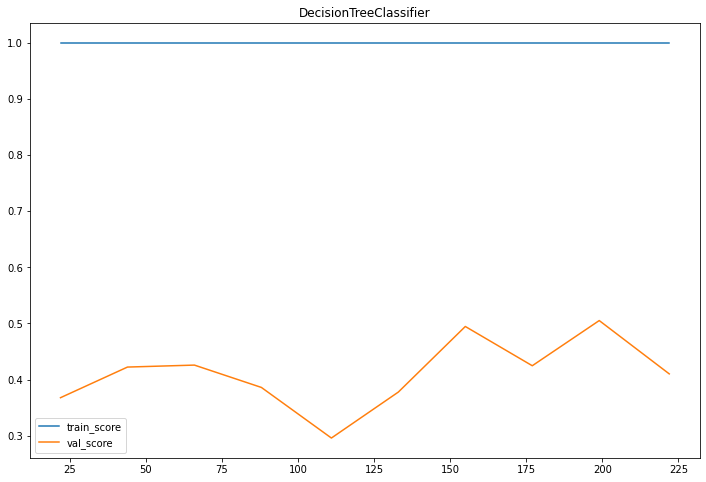

In [ ]:
evaluation(model, X_train, y_train, X_test, y_test)

>> ## Amélioration du modèle
- On peut essayer d'améliorer le modèle en modifiant nos étapes de pre processing ci dessous:
  - En lui donnant plus de valeurs pour lutter contre l'over fitting:
    - Suppression du dropna pour fillna avec valeurs extrêmes --> Not better
    - fillna avec moyenne de la colonne --> Not better
  - Selection des features: features importance
    - Meilleurs résultat en supprimant les variables de type viral.
  - Essai d'un nouvel estimateur: Modèle régularisé, aide à lutter contre l'over fitting --> random forest par exemple
    - On ajoute la colonne "est malade" comme fait précédemment dans l'EDA --> Amélioration avec le model de Decision tree
  - Mise en place d'une pipeline avec une feature selection K best (test Anova --> F test)
    - Best result avec 4 best features
  - Ajout de polynomial features et PCA à la pipeline

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

model= make_pipeline(PolynomialFeatures(3),
                     SelectKBest(f_classif, # test de anova
                                 k=20 ),# On sélectionne les 10 meilleures variables du f_classif
                     RandomForestClassifier(random_state=0)                     )

In [ ]:
# On découpe notre data frame
trainset, testset = train_test_split(df_, test_size= 0.2, random_state= 0)

print(trainset.shape)
print(testset.shape)

(4515, 33)
(1129, 33)


In [ ]:
def transform_label(x):
  """Transforme les labels négatifs:0 et positifs:1"""
  if x in ['not_detected', 'negative']:
    return 0
  if x in ['detected', 'positive']:
    return 1

# Créer variables avec variables existantes
def feature_engineering(df):
  df["est malade"]= df[viral_analysis_columns].sum(axis=1) >= 1  
  return df

def encodage(df):
  for col in df.select_dtypes('object'):
    df[col]= df[col].apply(transform_label)
  return df

def imputation(df): 
  df= df.drop(viral_analysis_columns, axis=1)   
  return df.dropna(axis=0)

In [ ]:
def preprocessing(df):
  df= encodage(df)
  df= feature_engineering(df)
  df= imputation(df)

  X= df.drop('SARS-Cov-2 exam result', axis= 1)
  y= df["SARS-Cov-2 exam result"]

  print(y.value_counts(), X.shape)

  return X, y

In [ ]:
# On définit nous X et y de train et test
X_train, y_train= preprocessing(trainset)
X_test, y_test= preprocessing(testset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64 (487, 16)
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64 (111, 16)


In [ ]:
X_test.shape

(111, 16)

In [ ]:
# Fonction pour évaluer le modèle
def evaluation(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  ypred= model.predict(X_test)
  
  print(f"{type(model).__name__:-<50}")
  print(confusion_matrix(y_true=y_test, y_pred=ypred))
  print(classification_report(y_test, ypred))

  # N: nombre échantillons
  # val_score: score de validation
  N, train_score, val_score= learning_curve(model, X_train, y_train, # modele et sets d'entrainement
                                            cv=4, # Cross validation
                                            scoring='f1',
                                            train_sizes= np.linspace(0.1, 1,  10) # Train size % de x_train, y_train
                                            )
  plt.figure(figsize=(12,8))
  plt.title(label= type(model).__name__)
  plt.plot(N, train_score.mean(axis= 1), label= 'train_score')
  plt.plot(N, val_score.mean(axis= 1), label= 'val_score')
  plt.legend()

Pipeline------------------------------------------
[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111



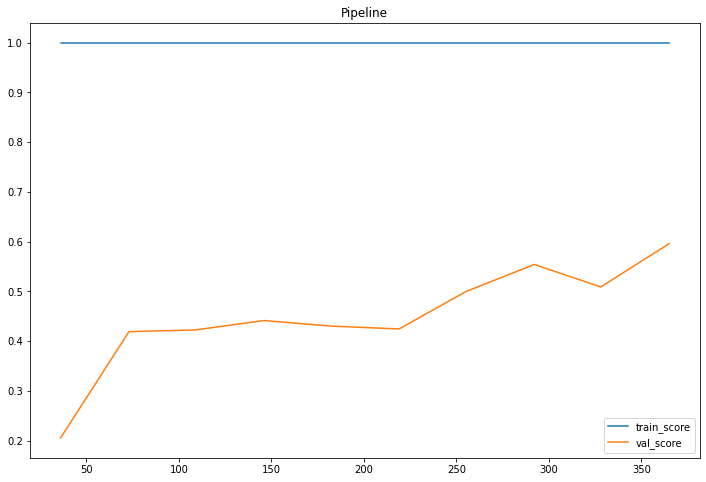

In [ ]:
evaluation(model, X_train, y_train, X_test, y_test)

>>> ### Features selection
- model.feature_importances_ --> donne l'importance de chaque feature pour le modèle
- On passe ce résultat dans un dataframe pandas avec pour index les colonnes de notre dataframe d'origine afin de mieux lire.
- On plot ensuite pour observer
- **Conclusion**: Les variables de type viral n'ont pas beaucoup d'importance dans l'entrainement du modèle, en les supprimant, on obtient des résultats un peu meilleurs


>> ## Modèle final de l'étude
- Après avoir évalué et améliorer un modèle de DecisionTreeClassifier et tester un modèle de RandomTreeClassifier, nous allons créer notre modèle final grâce à toutes les pistes que nous avons explorées.
- Modèles à tester:
  - DecisionTreeClassifier
  - RandomTreeClassifier
  - 

In [ ]:
# Modèles
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Optimisation
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
# Pipeline de preprocessing
preprocessor= make_pipeline(PolynomialFeatures(2),
                            SelectKBest(f_classif, k=10 ))

In [ ]:
RandomForest = make_pipeline(preprocessor, 
                            RandomForestClassifier(random_state=0))

AdaBoost = make_pipeline(preprocessor,
                        AdaBoostClassifier(random_state=0))

# Etape de normalisation nécessaire pour le SVC
SVM = make_pipeline(preprocessor,
                    StandardScaler(), 
                    SVC(random_state=0))

DecisionTree= make_pipeline(preprocessor,
                            RandomForestClassifier(random_state=0))

KNN= make_pipeline(preprocessor,
                   StandardScaler(),
                   KNeighborsClassifier())

In [ ]:
# On créé une liste de toutes ces pipelines de modèles
# Tuple (nom, model)
models= [("Adaboost", AdaBoost), 
         ("RandomForest", RandomForest), 
         ("SVM", SVM), 
         ("DecisionTree", DecisionTree), 
         ("KNN",KNN)]

In [ ]:
# On évalue nos modèles
for model in models:
  print(model[0])
  evaluation(model[1], X_train, y_train, X_test, y_test)

>> ## Conclusions évaluation
- Nous allons concentrer nos efforts sur le SVM(svc) et l'Adaboost pour cette recherche du meilleur modèle. En effet, ce sont ces deux modèles qui ont obtenus les meilleurs score de f1 sur le catégorie 1 (malade) de notre target

## Recherche des meilleurs hyper paramètres avec GridSearchCV et RandomizedSearchCV
- **GridSearchCV** est efficace sur un nombre limité de paramètres à tester, en effet toutes les combinaisons de paramètres donnés sont testée, très long sur un grand nombre de paramètres avec beaucoup de valeurs à tester
- **RandomizedSearchCV**, de son côté, permet de tester des combinaisons aléatoires des paramètres données dans l'intervalle de valeurs donné à chacun, cela va pouvoir augmenter drastiquement la vitesse d'exécution de la recherche.

In [ ]:
 from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

>>> ### SVM

In [ ]:
# Stages pipeline
SVM

In [ ]:
# Pour le SVC on va optimiser
# C: coef. de pénalité (pénalité l2 au carré)
# gamma: 
params= {
    'pipeline__polynomialfeatures__degree': [1,2,3,4],
    'pipeline__polynomialfeatures__include_bias':[True, False],
    'pipeline__selectkbest__k': range(1,100),
    'svc__gamma':np.linspace(1e-3, 1e-5, 100),
    'svc__C': np.linspace(1, 2000, 300)
}

In [ ]:
# On évalue sur le recall (fn) 
# Car un faux négatif est plus impactant dans le cas d'un malade qu'un faux positif
# grid= GridSearchCV(SVM, params, scoring= 'recall', cv= 4)
grid= RandomizedSearchCV(SVM, params, scoring= 'recall', cv= 4)

In [ ]:
# On affiche les best params trouvés pour les paramètres fournis
grid.fit(X_train, y_train)

print(grid.best_params_)
# 'svc__C': 828.0344827586207, 'svc__gamma': 0.001

{'svc__gamma': 0.0009400000000000001, 'svc__C': 1979.943143812709, 'pipeline__selectkbest__k': 57, 'pipeline__polynomialfeatures__include_bias': False, 'pipeline__polynomialfeatures__degree': 3}


In [ ]:
# On affiche le résultat
y_pred= grid.predict(X_test)
print(classification_report(y_test, y_pred, output_dict=True))

{'0': {'precision': 0.9166666666666666, 'recall': 0.9263157894736842, 'f1-score': 0.9214659685863874, 'support': 95}, '1': {'precision': 0.5333333333333333, 'recall': 0.5, 'f1-score': 0.5161290322580646, 'support': 16}, 'accuracy': 0.8648648648648649, 'macro avg': {'precision': 0.725, 'recall': 0.7131578947368421, 'f1-score': 0.718797500422226, 'support': 111}, 'weighted avg': {'precision': 0.8614114114114113, 'recall': 0.8648648648648649, 'f1-score': 0.8630390228093319, 'support': 111}}


- "0.5625": {
        "svc__gamma": 0.00084,
        "svc__C": 1679.0903010033444,
        "pipeline__selectkbest__k": 50,
        "pipeline__polynomialfeatures__include_bias": false,
        "pipeline__polynomialfeatures__degree": 3
    }

In [ ]:
# On peut aussi faire cela avec une boucle dans laquelle on va rechercher
# le meilleur recall possible pour notre classe 1.
import json

dict_recall= {}
while True:
  grid= RandomizedSearchCV(SVM, params, scoring= 'recall', cv= 4)
  grid.fit(X_train, y_train)
  best= grid.best_params_

  y_pred= grid.predict(X_test)
  recall= classification_report(y_test, y_pred, output_dict=True)['1']['recall']
  f1= classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
  dict_recall[recall]= best
  if recall >= 0.5625 and f1 >=0.6:
    break
print(json.dumps(dict_recall, indent=4))
print(classification_report(y_test, y_pred, output_dict=False))

In [ ]:
model= make_pipeline(PolynomialFeatures(degree=3, 
                                           include_bias=False),
                      SelectKBest(f_classif, 
                                  k=50),
                      StandardScaler(), 
                      SVC(C=1679.0903010033444, 
                          gamma=0.00084,
                          random_state=0)
                        )
evaluation(model, X_train, y_train, X_test, y_test)

>> ## Precision/recall curve
- On va observer les courbes de precision et de recall 
- On va définir un seuil (threshold) de prediction pour notre modèle
- **precision_recall_curve**: permet de déterminer la future precision et recall du modèle en fonction d'un seuil de prediction que nous allons définir
- Tous les modèles ont une decision_function:
  - **Ex: Régression logistique** --> Si la probabilité sig(t) (decision function) est supérieure à un certain seuil alors la décision est 1, sinon 0

In [ ]:
from sklearn.metrics import precision_recall_curve

<function sklearn.pipeline.Pipeline.decision_function>

In [ ]:
# precision_recall_curve va retourner un array pour precision, recall et threshold
# On pourra ainsi voir notre recall (ou precision, mais nous favorisons le score recall) 
# en fonction du threshold (seuil) à donner à notre decision function
precision, recall, threshold= precision_recall_curve(y_train, model.decision_function(X_train))

- On observe donc notre precision_recall_curve, en faisant un plot du recall et de la precision en fonction du threshold de notre decision_function.
- On va devoir choisir un threshold pour avoir le meilleur recall possible tout en ne sacrifiant pas notre precision.
- On va choisir un threshold de ~[-0.6, -0.8]

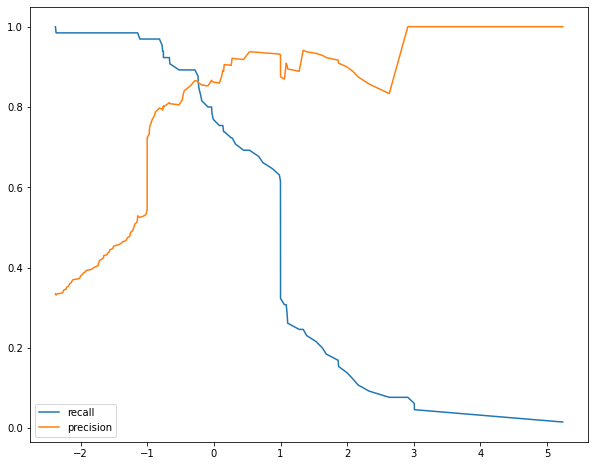

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(threshold, recall[:-1],  label= 'recall')
plt.plot(threshold, precision[:-1], label='precision')
plt.legend()

>> ## Finalisation du modèle choisi et optimisé

In [ ]:
# Fonction retournant si la valeur de y_pred est supérieure ou non au threshold donné
# On va donc retourner true si cette condition est vraie sinon false
# On fixe ainsi un seuil de décision différent de celui de base pour notre décision finale
def final_model(model, X, threshold=-0.6):
    return model.decision_function(X) > threshold

In [ ]:
y_pred= final_model(model, X_test, threshold=-1)

In [ ]:
f1_score(y_test, y_pred)

0.5853658536585366

In [ ]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.75
0.48
